**Thought Process**  
We begin by importing all the necessary libraries for data handling, feature extraction, model definition, and evaluation. This cell sets up the environment so subsequent cells can focus on specific tasks without worrying about missing imports.

In [ ]:
!pip install -q sentence-transformers textstat datasets transformers

In [ ]:
# Cell 1: Imports and Setup
# 1) Mount your Drive
from google.colab import drive
drive.mount('/content/drive')

import os, json, re, nltk, textstat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from scipy.stats import entropy
from joblib import Parallel, delayed

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler

from sentence_transformers import SentenceTransformer
from transformers import (
    DistilBertTokenizerFast, DistilBertForSequenceClassification,
    GPT2TokenizerFast, GPT2LMHeadModel
)
from datasets import load_dataset

import multiprocessing as mp


# Device Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# NLTK setup
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('averaged_perceptron_tagger')

# Multiprocessing setup
if __name__ == "__main__":
    mp.set_start_method("spawn", force=True)

Mounted at /content/drive
Device: cuda


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


**Thought Process**  
Load and label the real “small‑117M” GPT‑2 outputs vs. WebText human examples.


In [ ]:
# Cell 2: Data Loading & Sampling

def load_jsonl(path, max_lines=None):
    recs=[]
    with open(path,'r',encoding='utf-8') as f:
        for i,line in enumerate(f,1):
            if max_lines and i>max_lines: break
            try: recs.append(json.loads(line))
            except: continue
    return pd.DataFrame(recs)

gpt_path = 'small-117M.train.jsonl'
human_path = 'webtext.train.jsonl'

gpt_df    = load_jsonl(gpt_path, max_lines=250_000)
human_df  = load_jsonl(human_path, max_lines=250_000)
gpt_df['label'], human_df['label'] = 1, 0

df = pd.concat([gpt_df, human_df]).sample(frac=1,random_state=42)
train_df, temp = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df= train_test_split(temp, test_size=0.5, stratify=temp['label'], random_state=42)
print("Splits:", len(train_df), len(val_df), len(test_df))

Splits: 400000 50000 50000


**Thought Process**  
**TF‑IDF**: unigrams+bigrams, top 10 000.  
**Embeddings**: same.  
**Stylometric**: add TTR, avg word len, punctuation density.  


In [ ]:
# Cell 3: Stylometric Feature Extraction

def featurize_one(text):
    # single tokenization pass
    sentences = nltk.sent_tokenize(text)
    words     = nltk.word_tokenize(text)

    # 1) avg sentence length
    sent_lengths = [len(nltk.word_tokenize(s)) for s in sentences] or [0]
    avg_sent_len = np.mean(sent_lengths)

    # 2) flesch reading ease
    fre = textstat.flesch_reading_ease(text)

    # 3) avg word length
    word_lengths = [len(w) for w in words] or [0]
    avg_word_len = np.mean(word_lengths)

    # 4) type–token ratio
    ttr = len(set(words)) / (len(words) + 1)

    # 5) punctuation density
    punc = sum(c in '.,;:!?' for c in text) / (len(text) + 1)

    # 6) POS bigram frequencies (top 5)
    tags = [tag for _, tag in nltk.pos_tag(words)]
    bigrams = list(zip(tags, tags[1:]))
    bg_counts = Counter(bigrams)
    top5 = [count for _, count in bg_counts.most_common(5)]
    top5 += [0] * (5 - len(top5))

    # 7) avg clause length
    clauses = re.split(r'[;,]', text)
    clause_lens = [len(nltk.word_tokenize(c)) for c in clauses] or [0]
    avg_clause_len = np.mean(clause_lens)

    # 8) char‑3gram entropy
    chars = [text[i:i+3] for i in range(len(text) - 2)]
    ch_counts = Counter(chars)
    probs = np.array(list(ch_counts.values()), dtype=float)
    probs /= probs.sum() if probs.sum() > 0 else 1
    ch_entropy = -np.sum(probs * np.log2(probs + 1e-12))

    return [
        avg_sent_len, fre, avg_word_len, ttr, punc,
        *top5, avg_clause_len, ch_entropy
    ]

from joblib import Parallel, delayed

def stylometric_feats(texts, n_jobs=-1):
    """
    texts: list of str
    n_jobs: number of parallel jobs (−1 = all cores)
    Returns a (len(texts), F) numpy array of features.
    Ensures worker pools are cleanly closed.
    """
    with Parallel(n_jobs=n_jobs, backend="loky") as parallel:
        feat_list = parallel(delayed(featurize_one)(t) for t in texts)
    return np.array(feat_list)


# Usage:
X_styl_train = stylometric_feats(train_df['text'].tolist(), n_jobs=8)
X_styl_val   = stylometric_feats(val_df['text'].tolist(),   n_jobs=8)
X_styl_test  = stylometric_feats(test_df['text'].tolist(),  n_jobs=8)

print("New stylometric dim:", X_styl_train.shape[1])

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


New stylometric dim: 12


**Thought Process**  
Extract TF‑IDF and SentenceTransformer embeddings.

In [ ]:
# Cell 4: TF‑IDF & Embeddings
tfidf = TfidfVectorizer(max_features=10_000, ngram_range=(1,2))
X_tfidf_train = tfidf.fit_transform(train_df['text'])
X_tfidf_val   = tfidf.transform(val_df  ['text'])
X_tfidf_test  = tfidf.transform(test_df ['text'])

embed_model = SentenceTransformer('all-MiniLM-L6-v2')
X_emb_train = embed_model.encode(train_df['text'].tolist(), batch_size=64)
X_emb_val   = embed_model.encode(val_df  ['text'].tolist(), batch_size=64)
X_emb_test  = embed_model.encode(test_df ['text'].tolist(), batch_size=64)

y_train, y_val, y_test = train_df['label'].values, val_df['label'].values, test_df['label'].values
print("Feature dims:", X_tfidf_train.shape, X_emb_train.shape, X_styl_train.shape)

Feature dims: (400000, 10000) (400000, 384) (400000, 12)


**Thought Process**  
Train TF‑IDF (LogReg) and Stylometric (RF) experts.

In [ ]:
# Cell 5: Initialize Experts

# Expert 1
expert1 = LogisticRegression(max_iter=1000, C=1.0, class_weight='balanced')
expert1.fit(X_tfidf_train, y_train)

# Expert 3
expert3 = RandomForestClassifier(n_estimators=100, max_depth=25, class_weight='balanced', n_jobs=-1, random_state=42)
expert3.fit(X_styl_train, y_train)

# Quick eval
print("Expert1 on val:", accuracy_score(y_val, expert1.predict(X_tfidf_val)))
print("Expert3 on val:", accuracy_score(y_val, expert3.predict(X_styl_val)))


Expert1 on val: 0.81944
Expert3 on val: 0.88282


**Thought Process**  
**Expert 2 (DistilBERT):** define, sanity‑check, and pre-tokenize for Expert 2.

In [ ]:
# Cell 6: DistilBERT Expert

# 1) Tokenizer + model
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
expert2   = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=2
).to(device)
optim2    = optim.AdamW(expert2.parameters(), lr=2e-5)

def make_dataloader(texts, labels, batch_size=16):
    """
    texts: list of str
    labels: np.ndarray or list of ints
    """
    enc = tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )
    return DataLoader(TensorDataset(
        enc['input_ids'], enc['attention_mask'], torch.tensor(labels)
    ), batch_size=batch_size, shuffle=True)

# 2) Convert Series to list
train_texts = train_df['text'].tolist()
val_texts   = val_df  ['text'].tolist()
test_texts  = test_df ['text'].tolist()

train_loader2 = make_dataloader(train_texts, y_train)
val_loader2   = make_dataloader(val_texts,   y_val)

# 3) Fine‑tune for multiple epochs
expert2.train()
for epoch in range(3):
    epoch_loss = 0.0
    for input_ids, attention_mask, labels in train_loader2:
        input_ids, attention_mask, labels = (
            input_ids.to(device),
            attention_mask.to(device),
            labels.to(device),
        )
        optim2.zero_grad()
        out = expert2(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        out.loss.backward()
        optim2.step()
        epoch_loss += out.loss.item()
    print(f"Epoch {epoch+1} loss: {epoch_loss/len(train_loader2):.4f}")

# 4) Pre‑tokenize for inference
def pretokenize(texts):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

train_tokens = pretokenize(train_texts)
val_tokens   = pretokenize(val_texts)
test_tokens  = pretokenize(test_texts)

# Move to device when needed
train_input_ids, train_attention_mask = (
    train_tokens['input_ids'].to(device),
    train_tokens['attention_mask'].to(device),
)
val_input_ids, val_attention_mask = (
    val_tokens['input_ids'].to(device),
    val_tokens['attention_mask'].to(device),
)
test_input_ids, test_attention_mask = (
    test_tokens['input_ids'].to(device),
    test_tokens['attention_mask'].to(device),
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 loss: 0.2837
Epoch 2 loss: 0.1470
Epoch 3 loss: 0.0780


**Thought Process**  
Map GPT-2 perplexity to a logistic score.

In [ ]:
# Cell 7: Zero‑Shot Expert (per‑sample perplexity)

from transformers import GPT2TokenizerFast, GPT2LMHeadModel
import torch
import torch.nn as nn
import numpy as np

# Prepare GPT-2 tokenizer & model with a padding token
gpt2_tok = GPT2TokenizerFast.from_pretrained('gpt2')
gpt2_lm  = GPT2LMHeadModel.from_pretrained('gpt2').to(device).eval()
gpt2_tok.pad_token = gpt2_tok.eos_token
gpt2_lm.resize_token_embeddings(len(gpt2_tok))

# Cross-entropy loss without reduction
loss_fct = nn.CrossEntropyLoss(reduction='none')

def zero_shot_expert_probs(texts, batch_size=32, max_length=256):
    """
    texts: list[str]
    Returns an (n,2) array of probability estimates [P(human), P(ai)]
    by mapping per-sample GPT-2 perplexity to a logistic score.
    """
    perp = []
    gpt2_lm.eval()

    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]
        enc = gpt2_tok(
            batch,
            return_tensors='pt',
            padding='max_length',
            truncation=True,
            max_length=max_length
        ).to(device)

        with torch.no_grad():
            outputs = gpt2_lm(
                input_ids=enc.input_ids,
                attention_mask=enc.attention_mask
            )
            logits = outputs.logits  # (B, L, V)

        # shift for language modeling: predict token t from t-1
        shift_logits = logits[:, :-1, :].contiguous()           # (B, L-1, V)
        shift_labels = enc.input_ids[:, 1:].contiguous()        # (B, L-1)
        shift_mask   = enc.attention_mask[:, 1:].contiguous()   # (B, L-1)

        # flatten and compute per-token loss
        B, Lm1, V = shift_logits.size()
        flat_logits = shift_logits.view(-1, V)                 # (B*(L-1), V)
        flat_labels = shift_labels.view(-1)                    # (B*(L-1))
        flat_loss   = loss_fct(flat_logits, flat_labels)       # (B*(L-1))
        loss_per_token = flat_loss.view(B, Lm1)                # (B, L-1)

        # mask out padding positions, then average
        mask = shift_mask.float()
        token_sums = (loss_per_token * mask).sum(dim=1)        # (B,)
        token_counts = mask.sum(dim=1).clamp(min=1.0)          # (B,)
        per_sample_nll = token_sums / token_counts             # (B,)

        # perplexity per sample
        batch_perp = torch.exp(per_sample_nll).cpu().numpy()   # (B,)
        perp.extend(batch_perp.tolist())

        # cleanup
        del enc, outputs, logits, shift_logits, shift_labels, flat_logits, flat_labels, flat_loss
        torch.cuda.empty_cache()

    perp = np.array(perp)  # shape (n,)

    # map perplexity to P(ai) via logistic:  score = -(perp - μ)/σ
    mu, sigma = perp.mean(), perp.std() + 1e-12
    scores = - (perp - mu) / sigma
    p_ai    = 1 / (1 + np.exp(-scores))
    p_human = 1 - p_ai

    return np.vstack([p_human, p_ai]).T  # shape (n,2)

# --- Quick sanity check ---
if __name__ == "__main__":
    test_texts = ["Hello world!", "This is a GPT‑2 vs human test."]
    probs = zero_shot_expert_probs(test_texts, batch_size=2, max_length=32)
    print("Output shape:", probs.shape)   # should be (2,2)
    print("Sample probabilities:\n", probs)

Output shape: (2, 2)
Sample probabilities:
 [[0.26894142 0.73105858]
 [0.73105858 0.26894142]]


**Thought Process**  
Define a learnable gating MLP with temperature scaling.
**Gating Network**: deeper + BN + dropout. Input = [embeddings | stylometric].  


In [ ]:
# Cell 8: Gating Network Definition + Input Prep

class GatingNet(nn.Module):
    def __init__(self, D, K):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(D, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, K)
        )
        self.temperature = nn.Parameter(torch.ones(1))

    def forward(self, x):
        logits = self.net(x)
        scaled = logits / self.temperature.clamp(min=0.1)
        return torch.softmax(scaled, dim=-1)

def compute_gate_inputs(
    texts,                  # List[str]
    X_emb,                  # np.ndarray (n, D_emb)
    X_styl,                 # np.ndarray (n, D_styl)
    tfidf_matrix,           # scipy.sparse (n, D_tfidf)
    input_ids,              # torch.Tensor (n, L)
    attention_mask,         # torch.Tensor (n, L)
    scaler=None,
    batch_size=32,
    max_length=256
):
    n = len(texts)

    # 1) Expert posteriors
    p1 = expert1.predict_proba(tfidf_matrix)               # (n,2)

    expert2.eval()
    p2_batches = []
    with torch.no_grad():
        for i in range(0, n, batch_size):
            ids  = input_ids[i:i+batch_size].to(device)
            mask = attention_mask[i:i+batch_size].to(device)
            out  = expert2(input_ids=ids, attention_mask=mask)
            p2_batches.append(torch.softmax(out.logits, dim=-1).cpu().numpy())
    p2 = np.vstack(p2_batches)                             # (n,2)

    p3 = expert3.predict_proba(X_styl)                     # (n,2)
    p4 = zero_shot_expert_probs(texts, batch_size, max_length)  # (n,2)

    # 2) Entropies & margins for each expert
    ent = np.stack([
        entropy(p1.T), entropy(p2.T), entropy(p3.T), entropy(p4.T)
    ], axis=1)                                             # (n,4)
    mar = np.stack([
        np.abs(p1[:,0]-p1[:,1]),
        np.abs(p2[:,0]-p2[:,1]),
        np.abs(p3[:,0]-p3[:,1]),
        np.abs(p4[:,0]-p4[:,1])
    ], axis=1)                                             # (n,4)

    # 3) Meta‑features: ent+mar
    meta = np.hstack([ent, mar])                           # (n,8)

    # 4) Scale meta
    if scaler is None:
        scaler = MinMaxScaler().fit(meta)
    meta = scaler.transform(meta)

    # 5) Final gate inputs
    gate_X = np.hstack([X_emb, X_styl, meta])              # (n, D_emb+D_styl+8)
    return gate_X, scaler

gate_train, gate_scaler = compute_gate_inputs(
    train_df['text'].tolist(),
    X_emb_train, X_styl_train, X_tfidf_train,
    train_input_ids, train_attention_mask,
    scaler=None
)
gate_val, _ = compute_gate_inputs(
    val_df['text'].tolist(),
    X_emb_val, X_styl_val, X_tfidf_val,
    val_input_ids, val_attention_mask,
    scaler=gate_scaler
)
gate_test, _ = compute_gate_inputs(
    test_df['text'].tolist(),
    X_emb_test, X_styl_test, X_tfidf_test,
    test_input_ids, test_attention_mask,
    scaler=gate_scaler
)

# initialize gating network
num_experts = 4
gating = GatingNet(gate_train.shape[1], num_experts).to(device)
opt_g   = optim.AdamW(gating.parameters(), lr=1e-3, weight_decay=1e-4)
ce_loss = nn.CrossEntropyLoss()

**Thought Process**  
**EM Loop**: 50 iterations, log-domain responsibilities, re-weighted retraining, early stop on val F1.  


In [ ]:
# Cell 9: EM Training Loop

best_val_f1 = 0.0
patience     = 0

# Precompute train texts & zero‑shot once
train_texts = train_df['text'].tolist()
n = len(train_texts)
idx = np.arange(n)
p4_all = zero_shot_expert_probs(train_texts)              # shape (n,2)

# Precompute Expert 2 val posteriors once (on CPU, small batches)
expert2.eval()
p2_val_probs = []
batch_size = 32
for i in range(0, len(val_texts), batch_size):
    batch = val_texts[i:i+batch_size]
    enc = tokenizer(
        batch,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    ).to(device)
    with torch.no_grad():
        out = expert2(**enc)
    p2_val_probs.append(torch.softmax(out.logits, dim=-1).cpu().numpy())
    del enc, out
    torch.cuda.empty_cache()
p2_val_probs = np.vstack(p2_val_probs)                     # shape (n_val, 2)

# Precompute Expert 4 val posteriors once
p4_val_all = zero_shot_expert_probs(val_texts)             # shape (n_val, 2)

for epoch in range(50):
    # --- E‑step ---
    p1 = expert1.predict_proba(X_tfidf_train)[idx, y_train]     # (n,)

    # Expert2 on train
    expert2.eval()
    p2_probs = []
    for i in range(0, n, 32):
        batch_texts = train_texts[i : i+32]
        enc = tokenizer(batch_texts, padding='max_length',
                        truncation=True, max_length=128,
                        return_tensors='pt').to(device)
        with torch.no_grad():
            out = expert2(**enc)
        soft = torch.softmax(out.logits, dim=-1).cpu().numpy()
        labs = y_train[i : i+soft.shape[0]]
        p2_probs.extend(soft[np.arange(len(labs)), labs])
        del enc, out
        torch.cuda.empty_cache()
    p2 = np.array(p2_probs)  # (n,)

    p3 = expert3.predict_proba(X_styl_train)[idx, y_train]       # (n,)

    p4 = p4_all[idx, y_train]                                    # (n,)

    # Gating
    gating.eval()
    with torch.no_grad():
        pi = gating(torch.from_numpy(gate_train).float().to(device)).cpu().numpy()  # (n,4)

    # Responsibilities
    expert_ps = np.stack([p1, p2, p3, p4], axis=1)               # (n,4)
    log_r     = np.log(pi+1e-12) + np.log(expert_ps+1e-12)
    R         = np.exp(log_r - log_r.max(axis=1, keepdims=True))
    R        /= R.sum(axis=1, keepdims=True)

    # --- M‑step ---
    expert1.fit(X_tfidf_train, y_train, sample_weight=R[:,0])
    expert3.fit(X_styl_train,   y_train, sample_weight=R[:,2])

    # fine‑tune expert2
    expert2.train()
    ds2 = TensorDataset(
        train_tokens['input_ids'], train_tokens['attention_mask'],
        torch.from_numpy(y_train).long(),
        torch.from_numpy(R[:,1]).float()
    )
    for ids, masks, labs, w in DataLoader(ds2, batch_size=16, shuffle=True):
        ids, masks, labs, w = ids.to(device), masks.to(device), labs.to(device), w.to(device)
        optim2.zero_grad()
        out = expert2(input_ids=ids, attention_mask=masks)
        losses = ce_loss(out.logits, labs)
        (losses * w).mean().backward()
        optim2.step()
    torch.cuda.empty_cache()

    # update gate
    gating.train()
    ds_g = TensorDataset(
        torch.from_numpy(gate_train).float(),
        torch.from_numpy(R).float()
    )
    for xg, rg in DataLoader(ds_g, batch_size=256, shuffle=True):
        xg, rg = xg.to(device), rg.to(device)
        opt_g.zero_grad()
        logits = gating(xg)
        loss_g = -(rg * torch.log(logits+1e-12)).sum(dim=1).mean()
        loss_g.backward()
        opt_g.step()
    torch.cuda.empty_cache()

    # --- Validation & Early Stop ---
    gating.eval()
    with torch.no_grad():
        pi_val = gating(torch.from_numpy(gate_val).float().to(device)).cpu().numpy()
    assign = pi_val.argmax(axis=1)
    preds  = np.zeros_like(y_val)

    # expert1 & expert3
    preds[assign==0] = expert1.predict(X_tfidf_val)[assign==0]
    preds[assign==2] = expert3.predict(X_styl_val)[assign==2]

    # expert2
    idx2 = np.where(assign==1)[0]
    preds[idx2] = p2_val_probs[idx2].argmax(axis=1)

    # zero-shot
    idx4 = np.where(assign==3)[0]
    preds[idx4] = (p4_val_all[idx4][:,1] > 0.5).astype(int)

    val_f1 = f1_score(y_val, preds)
    print(f"Epoch {epoch+1:02d} — Val F1: {val_f1:.4f}")
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience     = 0
    else:
        patience += 1
        if patience >= 3:
            print("Early stopping.")
            break


Epoch 01 — Val F1: 0.6958
Epoch 02 — Val F1: 0.8513
Epoch 03 — Val F1: 0.9083
Epoch 04 — Val F1: 0.8804
Epoch 05 — Val F1: 0.9167
Epoch 06 — Val F1: 0.9252
Epoch 07 — Val F1: 0.9283
Epoch 08 — Val F1: 0.9285
Epoch 09 — Val F1: 0.9293
Epoch 10 — Val F1: 0.9300
Epoch 11 — Val F1: 0.9303
Epoch 12 — Val F1: 0.9307
Epoch 13 — Val F1: 0.9303
Epoch 14 — Val F1: 0.9302
Epoch 15 — Val F1: 0.9296
Early stopping.


**Thought Process**  
**Final Evaluation** on the held‑out test set for both accuracy and F1.  


In [ ]:
# Cell 0: Evaluation

# 1) Get gating probabilities for the test set
with torch.no_grad():
    pi_test = gating(
        torch.from_numpy(gate_test).float().to(device)
    ).cpu().numpy()

# 2) Decide which expert to use per sample
assign_test = pi_test.argmax(axis=1)   # (n_test,)
# Check the size of pi_test
print(pi_test.shape)

# 3) Prepare Expert 2 predictions via DistilBERT on tokenized test inputs
expert2.eval()
pred2_batches = []
batch_size = 32
with torch.no_grad():
    for i in range(0, test_input_ids.size(0), batch_size):
        ids  = test_input_ids    [i : i+batch_size].to(device)
        mask = test_attention_mask[i : i+batch_size].to(device)
        out  = expert2(input_ids=ids, attention_mask=mask)
        pred2_batches.append(out.logits.argmax(dim=1).cpu().numpy())
pred2 = np.concatenate(pred2_batches)  # shape = (n_test,)


# 5) Build final prediction array
y_pred = np.zeros_like(y_test)

# Expert1 on TF‑IDF
mask1 = (assign_test == 0)
y_pred[mask1] = expert1.predict(X_tfidf_test)[mask1]

# Expert2 on DistilBERT
mask2 = (assign_test == 1)
y_pred[mask2] = pred2[mask2]

# Expert3 on Stylometric
mask3 = (assign_test == 2)
y_pred[mask3] = expert3.predict(X_styl_test)[mask3]

mask4 = (assign_test == 3)
p4_test = zero_shot_expert_probs(test_df['text'].tolist(), batch_size=32, max_length=256)
y_pred[mask4] = p4_test[mask4][:,1] > 0.5  # threshold at 0.5

# 6) Overall metrics
acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)
print(f"**Final MoE Test** — Acc: {acc:.4f}, F1: {f1:.4f}")

# 7) Per‑Expert breakdown
results = {}
masks = [mask1, mask2, mask3]
for k, mask in enumerate(masks, start=1):
    if mask.sum() < 10:
        continue
    acc_k = accuracy_score(y_test[mask], y_pred[mask])
    f1_k  = f1_score    (y_test[mask], y_pred[mask])
    avg_conf = pi_test[mask, k-1].mean()
    results[f"Expert {k}"] = {
        "n_samples": int(mask.sum()),
        "acc": acc_k,
        "f1": f1_k,
        "mean_gate_prob": avg_conf
    }
display(pd.DataFrame(results).T)

(50000, 4)
**Final MoE Test** — Acc: 0.9247, F1: 0.9217


,n_samples,acc,f1,mean_gate_prob
Expert 2,20993.0,0.843519,0.806548,0.769738
Expert 3,28999.0,0.983482,0.984580,0.577002


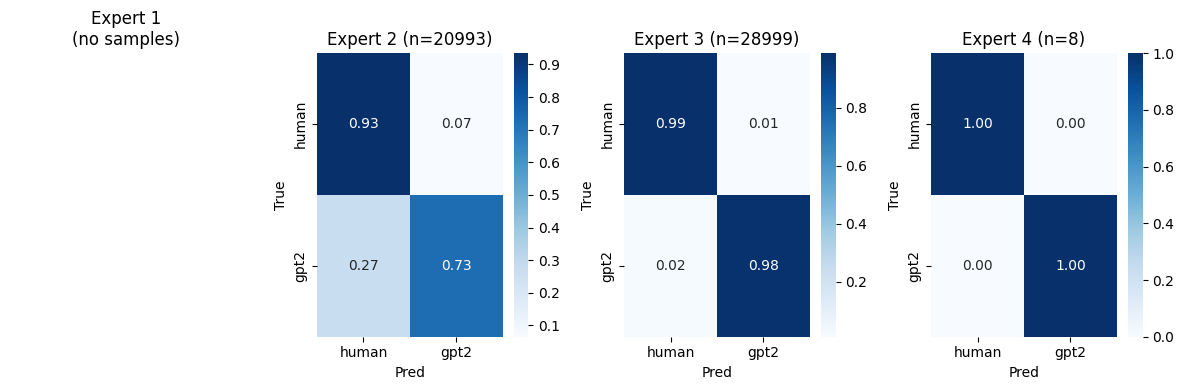

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
for i, ax in enumerate(axs.flatten()):
    mask = (assign_test == i)
    if mask.sum() < 1:
        # no samples assigned to expert i+1 – skip plotting
        ax.axis('off')
        ax.set_title(f"Expert {i+1}\n(no samples)")
        continue

    cm = confusion_matrix(y_test[mask], y_pred[mask], normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", ax=ax,
                xticklabels=['human','gpt2'], yticklabels=['human','gpt2'])
    ax.set_title(f"Expert {i+1} (n={mask.sum()})")
    ax.set_xlabel("Pred")
    ax.set_ylabel("True")
plt.tight_layout()
plt.show()

Validation Accuracies:
  Expert 1 (LogReg)        : 0.7708
  Expert 2 (DistilBERT)    : 0.8699
  Expert 3 (RF‑Stylometrics): 0.8825
  Expert 4 (Zero‑Shot)     : 0.3640


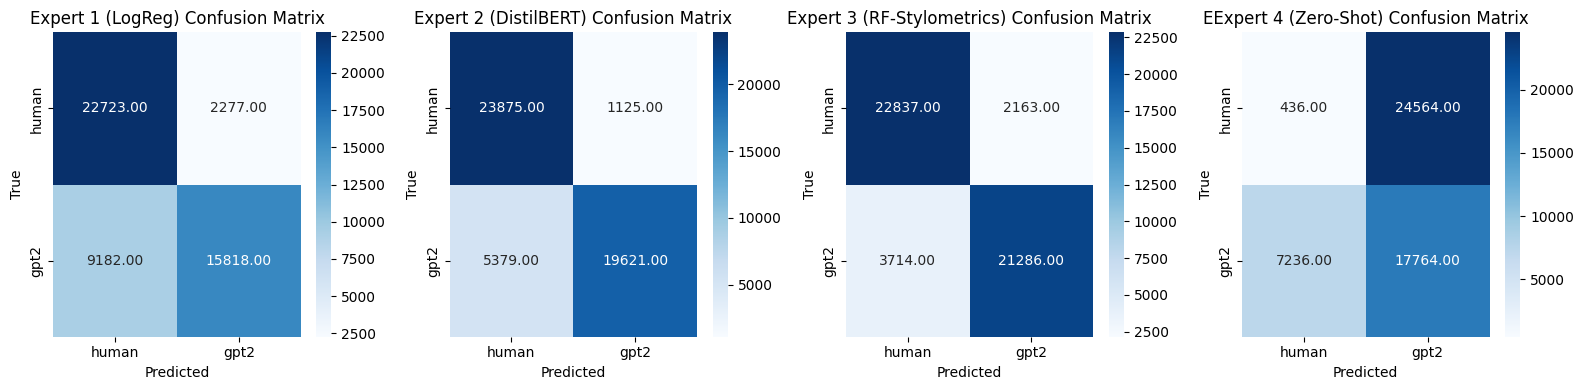

In [ ]:
# Cell 0.5: Expert Validation Diagnostics

import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# 1) Expert 1 on TF‑IDF
y_val_pred1 = expert1.predict(X_tfidf_val)
acc1 = accuracy_score(y_val, y_val_pred1)
cm1  = confusion_matrix(y_val, y_val_pred1)

# 2) Expert 2 on DistilBERT
expert2.eval()
pred2_batches = []
batch_size = 32
with torch.no_grad():
    for i in range(0, val_tokens['input_ids'].size(0), batch_size):
        ids  = val_tokens['input_ids'][i : i+batch_size].to(device)
        mask = val_tokens['attention_mask'][i : i+batch_size].to(device)
        out  = expert2(input_ids=ids, attention_mask=mask)
        pred2_batches.append(out.logits.argmax(dim=1).cpu().numpy())
y_val_pred2 = np.concatenate(pred2_batches)
acc2 = accuracy_score(y_val, y_val_pred2)
cm2  = confusion_matrix(y_val, y_val_pred2)

# 3) Expert 3 on Stylometric / RandomForest
y_val_pred3 = expert3.predict(X_styl_val)
acc3 = accuracy_score(y_val, y_val_pred3)
cm3  = confusion_matrix(y_val, y_val_pred3)

# 4) Expert 4 Zero‑Shot (perplexity→logistic)
zs_probs    = zero_shot_expert_probs(val_df['text'].tolist(), batch_size=32, max_length=256)
y_val_pred4 = (zs_probs[:,1] > 0.5).astype(int)
acc4 = accuracy_score(y_val, y_val_pred4)
cm4  = confusion_matrix(y_val, y_val_pred4)

# 5) Summary table
rows = [
    ("Expert 1 (LogReg)",         acc1),
    ("Expert 2 (DistilBERT)",     acc2),
    ("Expert 3 (RF‑Stylometrics)", acc3),
    ("Expert 4 (Zero‑Shot)",      acc4),
]

print("Validation Accuracies:")
for name, acc in rows:
    print(f"  {name:25s}: {acc:.4f}")

# 6) Plot confusion matrices side by side
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for ax, (name, cm) in zip(axs, [
        ("Expert 1 (LogReg)", cm1),
        ("Expert 2 (DistilBERT)", cm2),
        ("Expert 3 (RF‑Stylometrics)", cm3),
        ("EExpert 4 (Zero‑Shot)", cm4),
    ]):
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", ax=ax,
                xticklabels=['human','gpt2'], yticklabels=['human','gpt2'])
    ax.set_title(f"{name} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()


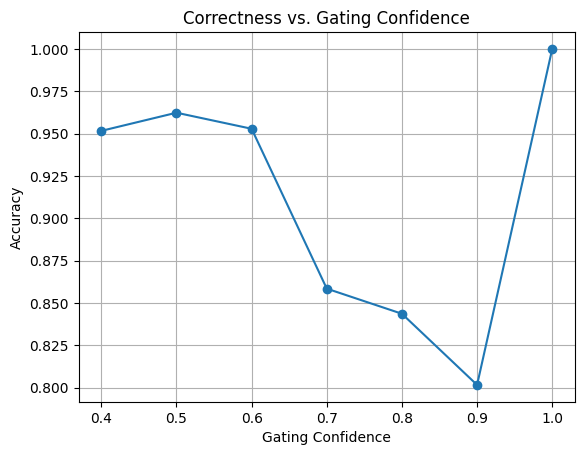

In [ ]:
confidences = pi_test.max(axis=1)
correct = (y_pred == y_test).astype(int)

# Bin by gating confidence
bins = np.linspace(0,1,11)
bin_ids = np.digitize(confidences, bins) - 1
acc_by_conf = [ correct[bin_ids==i].mean() if (bin_ids==i).sum()>0 else np.nan
                for i in range(len(bins)) ]

plt.plot(bins, acc_by_conf, marker='o')
plt.xlabel("Gating Confidence")
plt.ylabel("Accuracy")
plt.title("Correctness vs. Gating Confidence")
plt.grid(True)
plt.show()

**Thought Process**  
Before deciding on further refinements, we want to understand *where* our mixture is making errors. In the **error‑bucket analysis** we’ll group the test examples by gating confidence bins and by assigned expert, then compute accuracy and error counts in each bucket. This will tell us if the gate is over‑ or under‑confident in particular regions, and whether any expert’s errors are concentrated in low/high confidence buckets. Next, we’ll perform a **gate temperature sweep**: by varying the gating softmax temperature \(T\), we can see how sharpened vs. softened gating distributions affect overall mixture performance (accuracy & F1). This will guide whether we need to retrain the gate or adjust its temperature hyperparameter.


<ipython-input-17-367e5d66e419>:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['expert','conf_bin'])


,expert,conf_bin,n_samples,accuracy,errors
0,1,0-10%,0,NaN,NaN
1,1,10-20%,0,NaN,NaN
2,1,20-30%,0,NaN,NaN
3,1,30-40%,0,NaN,NaN
4,1,40-50%,700,0.941429,41.0
5,1,50-60%,4769,0.879849,573.0
6,1,60-70%,3164,0.859987,443.0
7,1,70-80%,2347,0.854282,342.0
8,1,80-90%,2398,0.843620,375.0
9,1,90-100%,7615,0.801576,1511.0


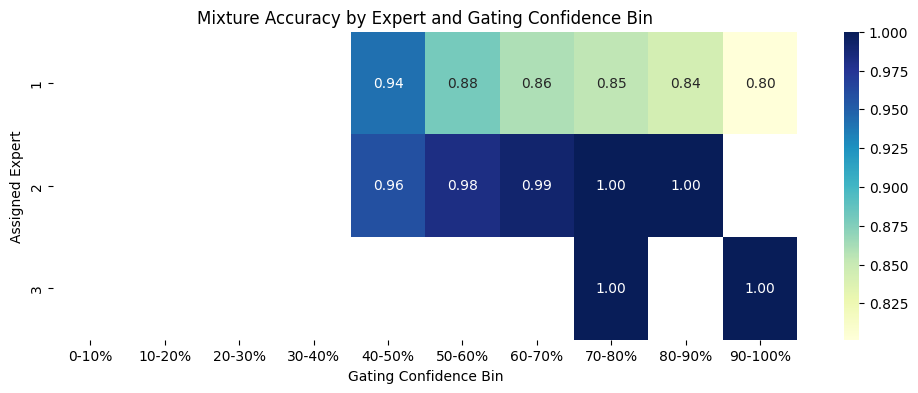

In [ ]:
# Cell 0.6: Error‑Bucket Analysis

# 1) Build a DataFrame of test predictions, true labels, assigned expert and gate confidence
#    gate_in_test, gating, expert1-4, y_test, y_pred, assign_test, pi_test are all defined
df_err = pd.DataFrame({
    'y_true':    y_test,
    'y_pred':    y_pred,
    'expert':    assign_test,
    'gate_conf': pi_test.max(axis=1)
})

# 2) Add a bucket column for gate_conf (deciles)
df_err['conf_bin'] = pd.cut(df_err['gate_conf'],
                            bins=np.linspace(0,1,11),
                            labels=[f"{i*10}-{(i+1)*10}%" for i in range(10)],
                            include_lowest=True)

# 3) Compute per‑bucket accuracy and counts, grouped by expert
bucket_stats = (
  df_err
  .assign(correct=lambda df: df['y_true'] == df['y_pred'])
  .groupby(['expert','conf_bin'])
  .agg(
    n_samples=('y_true','size'),
    accuracy=('correct','mean'),
    errors=('correct', lambda s: (~s).sum())
  )
  .reset_index()
)


display(bucket_stats)

# 4) Pivot for heatmap: experts on rows, conf_bins on columns, values=accuracy
pivot_acc = bucket_stats.pivot(index='expert', columns='conf_bin', values='accuracy')
plt.figure(figsize=(12,4))
sns.heatmap(pivot_acc, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Mixture Accuracy by Expert and Gating Confidence Bin")
plt.xlabel("Gating Confidence Bin")
plt.ylabel("Assigned Expert")
plt.show()


In [ ]:
# Cell X: Save Model Checkpoints to Google Drive



# 2) Create a directory for checkpoints
import os, joblib, torch
ckpt_dir = '/content/drive/MyDrive/MoE_checkpoints'
os.makedirs(ckpt_dir, exist_ok=True)

# 3) Save scikit‑learn experts and transformers
joblib.dump(expert1, os.path.join(ckpt_dir, 'expert1_logreg.joblib'))
joblib.dump(expert3, os.path.join(ckpt_dir, 'expert3_rf.joblib'))
joblib.dump(tfidf,    os.path.join(ckpt_dir, 'tfidf_vectorizer.joblib'))
joblib.dump(gate_scaler, os.path.join(ckpt_dir, 'gate_scaler.joblib'))

# 4) Save DistilBERT expert
#    – save weights and tokenizer/config so you can reload with from_pretrained()
expert2.save_pretrained(os.path.join(ckpt_dir, 'expert2_distilbert'))
tokenizer.save_pretrained(os.path.join(ckpt_dir, 'expert2_distilbert'))

# 5) Save the zero‑shot GPT‑2 LM (optional, since it's from HuggingFace)
gpt2_lm.save_pretrained(os.path.join(ckpt_dir, 'gpt2_lm'))
gpt2_tok.save_pretrained(os.path.join(ckpt_dir, 'gpt2_lm'))

# 6) Save gating network
torch.save({
    'model_state_dict': gating.state_dict(),
    'temperature': gating.temperature.detach().cpu().item(),
}, os.path.join(ckpt_dir, 'gating_net.pt'))

print(f"All checkpoints saved under {ckpt_dir}")


All checkpoints saved under /content/drive/MyDrive/MoE_checkpoints


**Thought Process**  
Now we sweep the gating temperature parameter \(T\). For each candidate \(T\), we set the gate’s `temperature` to \(T\), recompute the mixture predictions on the test set, and record overall accuracy and F1. Plotting these curves reveals whether sharpening (\(T<1\)) or softening (\(T>1\)) the gate improves performance.


In [ ]:
# Cell X: Interactive Evaluation

# 1) Prompt for input
sentence = input("Enter a sentence for evaluation: ")

# 2) Expert 1 (Logistic Regression on TF-IDF)
X_tfidf_single = tfidf.transform([sentence])
p1 = expert1.predict_proba(X_tfidf_single)[0]  # [P(human), P(ai)]

# 3) Expert 2 (DistilBERT)
enc2 = tokenizer(
    [sentence],
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='pt'
).to(device)
expert2.eval()
with torch.no_grad():
    out2 = expert2(**enc2)
soft2 = torch.softmax(out2.logits, dim=-1).cpu().numpy()[0]
p2 = soft2  # [P(human), P(ai)]

# 4) Expert 3 (Random Forest on Stylometric)
X_styl_single = stylometric_feats([sentence], n_jobs=1)
p3 = expert3.predict_proba(X_styl_single)[0]  # [P(human), P(ai)]

# 5) Expert 4 (Zero-Shot via GPT-2 perplexity)
p4 = zero_shot_expert_probs([sentence], batch_size=1, max_length=256)[0]  # [P(human), P(ai)]

# 6) Prepare gating input for the mixture
#    - Embeddings
X_emb_single = embed_model.encode([sentence], batch_size=1)
#    - TF-IDF already computed
#    - Stylometric already computed
#    - Tokenization for expert2 inference
single_tokens = {
    'input_ids': enc2.input_ids,
    'attention_mask': enc2.attention_mask
}

gate_X_single, _ = compute_gate_inputs(
    [sentence],
    X_emb_single, X_styl_single, X_tfidf_single,
    single_tokens['input_ids'], single_tokens['attention_mask'],
    scaler=gate_scaler
)

# 7) Compute gating weights
gating.eval()
with torch.no_grad():
    pi_single = gating(torch.from_numpy(gate_X_single).float().to(device)).cpu().numpy()[0]

# 8) Compute mixture probabilities
#    Weighted sum of expert posteriors
p_mix = pi_single[0] * p1 + pi_single[1] * p2 + pi_single[2] * p3 + pi_single[3] * p4  # [P(human), P(ai)]

# 9) Display results
expert_names = ['LogReg (TF-IDF)', 'DistilBERT', 'RF-Stylometric', 'Zero-Shot GPT-2']
print("\nIndividual Expert Opinions:")
for name, probs in zip(expert_names, [p1, p2, p3, p4]):
    print(f"  {name.ljust(20)} → P(human)={probs[0]:.3f}, P(ai)={probs[1]:.3f}")

print("\nGating Weights:")
for name, weight in zip(expert_names, pi_single):
    print(f"  {name.ljust(20)} → weight={weight:.3f}")

print(f"\nMixture Model Output → P(human)={p_mix[0]:.3f}, P(ai)={p_mix[1]:.3f}")
assigned = expert_names[np.argmax(pi_single)]
print(f"Assigned Expert: {assigned}")